# Hydrology example from the Vistula catchment in Poland

The Vistula catchment is the largest catchment in Poland, with an area
of 194,424 km2. This notebook shows how a hydrological model can
evaluated using ModelSkill.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import modelskill as ms

In [2]:
fldr = Path("../data/Vistula")
df = pd.read_csv(fldr / "stations.csv", index_col=0)
df

In [3]:
def get_comparer(df, mods, id):
    """Get a Comparer object for a given model and station id"""
    q = ms.Quantity(name="Discharge", unit="m3/s")

    # create Observation object
    fp = fldr / mods[0] / f"{id}.csv"
    dfd = pd.read_csv(fp, index_col=0, parse_dates=True)
    o = ms.PointObservation(dfd, item="Qobs", name=df.loc[id].Station,
                            x=df.loc[id].Long, y=df.loc[id].Lat, quantity=q)
    
    # create ModelResult objects
    mm = []
    for m in mods:
        fp = fldr / m / f"{id}.csv"
        dfd = pd.read_csv(fp, index_col=0, parse_dates=True)
        mm.append(ms.PointModelResult(dfd, item="Qsim", name=m, quantity=q))
    
    return ms.match(obs=o, mod=mm)

## Compare a single observation with two model results

In [4]:
cmp = get_comparer(df, ["sim1","sim2"], df.index[0])
cmp

<Comparer>
Quantity: Discharge [m3/s]
Observation: VISTULA (TCZEW), n_points=3653
Model(s):
0: sim1
1: sim2

### Plots

timeseries, scatter, boxplot, hist, kde, qq, taylor

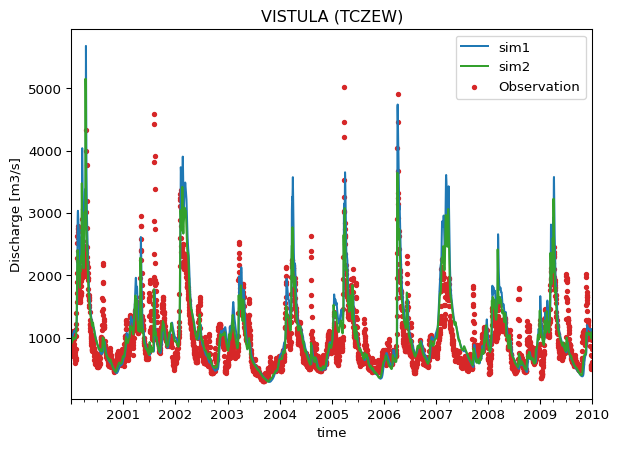

In [5]:
cmp.plot.timeseries();

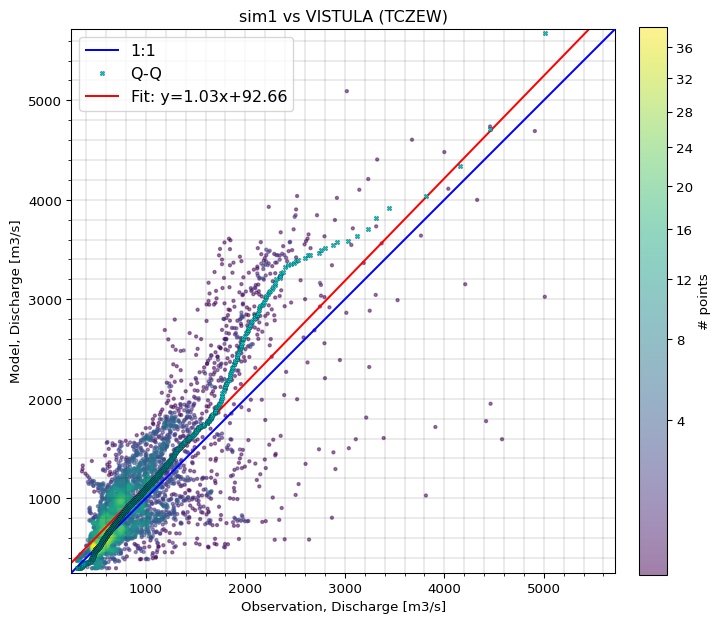

In [6]:
cmp.sel(model="sim1").plot.scatter();

### Summary statistics

In [7]:
# set default metrics
ms.options.metrics.list = ["kge", "cc"]

In [8]:
cmp.skill().round(3)

### Statistics aggregated by month

In [9]:
cmp.data["month"] = cmp.time.to_series().dt.month

In [10]:
cmp.skill(by=["model","month"]) #["kge"].plot.bar();

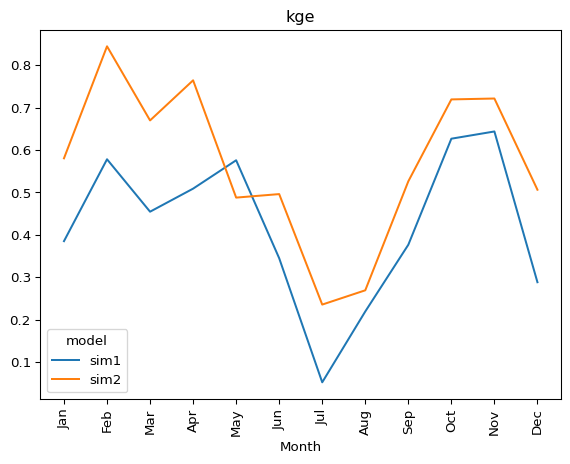

In [11]:
cmp.skill(by=["model","month"])["kge"].plot.line()
plt.xlabel("Month")
plt.xticks(np.arange(1,13), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]);

## Compare multiple observations with two model results

In [12]:
# loop through all stations in df and create a Comparer for each
cmps = []
for id in df.index:
   try:
      cmps.append(get_comparer(df, ["sim1","sim2"], id))
   except ValueError as e:
      pass
cc = ms.ComparerCollection(cmps)
cc   

<ComparerCollection>
Comparers:
0: VISTULA (TCZEW) - Discharge [m3/s]
1: PILICA (PRZEDBORZ) - Discharge [m3/s]
2: WIEPRZ (LUBARTOW) - Discharge [m3/s]
3: WIEPRZ (KRASNYSTAW) - Discharge [m3/s]
4: KAMIENNA (KUNOW) - Discharge [m3/s]
5: VISTULA (SANDOMIERZ) - Discharge [m3/s]
6: VISTULA (SZCZUCIN) - Discharge [m3/s]
7: DUNAJEC (NOWY SACZ) - Discharge [m3/s]
8: POPRAD (CHMELNICA) - Discharge [m3/s]
9: WISLOK (TRYNCZA) - Discharge [m3/s]
10: PISA (PTAKI) - Discharge [m3/s]
11: NAREW (SURAZ) - Discharge [m3/s]
12: LIWIEC (LOCHOW) - Discharge [m3/s]
13: KRZNA (MALOWA GORA) - Discharge [m3/s]

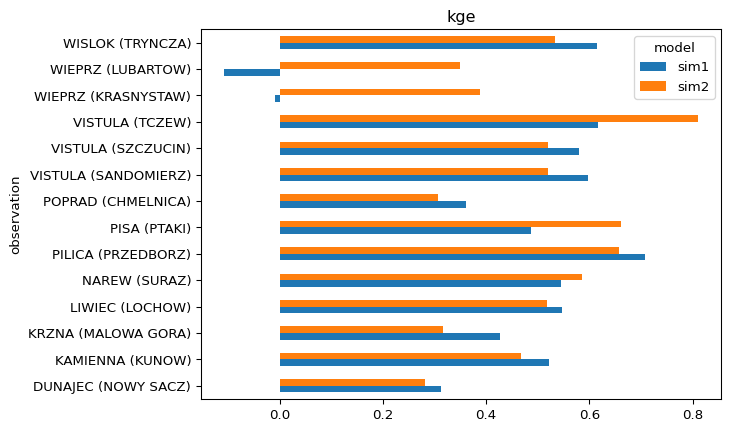

In [13]:
cc.skill(by=["model","observation"], metrics="kge")["kge"].plot.barh();

Average skill over all stations, weighted by $\sqrt{area}$.

In [14]:
weights = np.sqrt(df.set_index("Station")["Area"]).to_dict()
weights

{'VISTULA (TCZEW)': 440.36677894682293,
 'VISTULA (WARSAW (WARSZAWA))': 291.45342681121457,
 'PILICA (PRZEDBORZ)': 50.498514829646226,
 'WIEPRZ (LUBARTOW)': 79.93622457934825,
 'WIEPRZ (KRASNYSTAW)': 54.86528957364574,
 'KAMIENNA (KUNOW)': 33.32266495945365,
 'VISTULA (SANDOMIERZ)': 178.35330106280625,
 'VISTULA (SZCZUCIN)': 154.49692553575298,
 'DUNAJEC (NOWY SACZ)': 65.85894016760366,
 'POPRAD (CHMELNICA)': 35.52463933666322,
 'WISLOK (TRYNCZA)': 59.35991913741123,
 'PISA (PTAKI)': 59.79715712306062,
 'NAREW (SURAZ)': 58.52606257044805,
 'LIWIEC (LOCHOW)': 49.713177327545665,
 'KRZNA (MALOWA GORA)': 55.15342237794496}

In [15]:
cc.mean_skill(weights=weights).round(3)